In [44]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import os
import glob
from scipy.io import wavfile
import librosa
import librosa.display
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from scipy.io import wavfile

In [22]:
data_dir = '../../data/raw_data/zenodo.4008297/'
save_fp = '../../data/processed_data/specgram_db.npy'



In [23]:
data_fp = data_dir + 'B_ANI01_MC_FN_SIM01_301.wav'



visualize one sample

In [24]:
datasample, ratesample = librosa.load(data_fp, sr=None) 

print(ratesample)

8000


/opt/homebrew/anaconda3/lib/python3.11/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


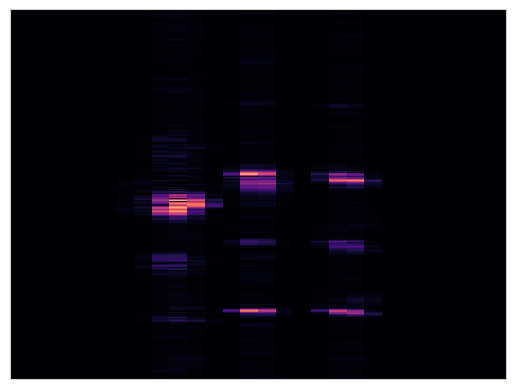

In [25]:
specgram_sample = librosa.stft(datasample)
librosa.display.specshow(specgram_sample)


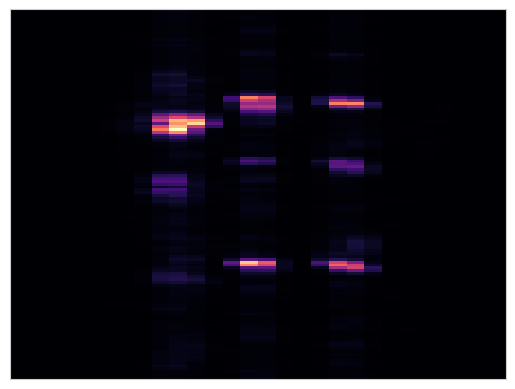

In [26]:
specmag_sample,_ = librosa.magphase(specgram_sample)
mel_scale_sgram_sample = librosa.feature.melspectrogram(S=specmag_sample,sr=ratesample)
librosa.display.specshow(mel_scale_sgram_sample)



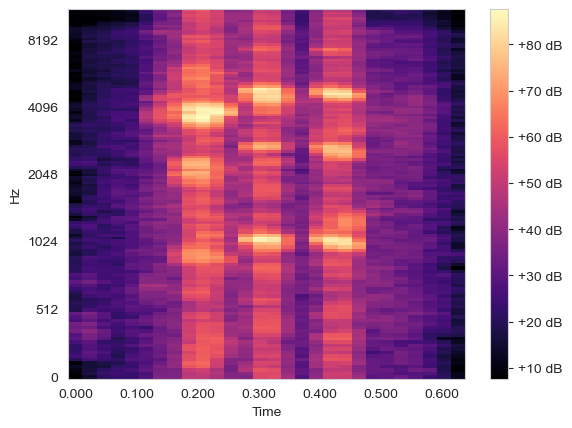

In [27]:
mel_spec_db_sample = librosa.amplitude_to_db(mel_scale_sgram_sample,ref=np.min)
librosa.display.specshow(mel_spec_db_sample, x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')



restore specgrams for all the data

In [28]:
##check all file has the same sampleing rate and channel number
data_fps = glob.glob(os.path.join(data_dir, '*'))
for data_fp in data_fps:
    datalib, ratelib = torchaudio.load(data_fp)
    #print(datalib.shape[0])
    if datalib.shape[0] != 1:
        print("diff channel number")
    if ratelib != 8000:
        print("diff sampling rate")

In [29]:
#save figures for all the data
data_fps = glob.glob(os.path.join(data_dir, '*'))
arrs = []
for data_fp in data_fps:
    datalib, ratelib = librosa.load(data_fp, sr=None)
    specgram = librosa.stft(datalib)
    specmag,_ = librosa.magphase(specgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=specmag,sr=ratelib)
    mel_spec_db = librosa.amplitude_to_db(mel_scale_sgram,ref=np.min)
    arrs.append(mel_spec_db)
    

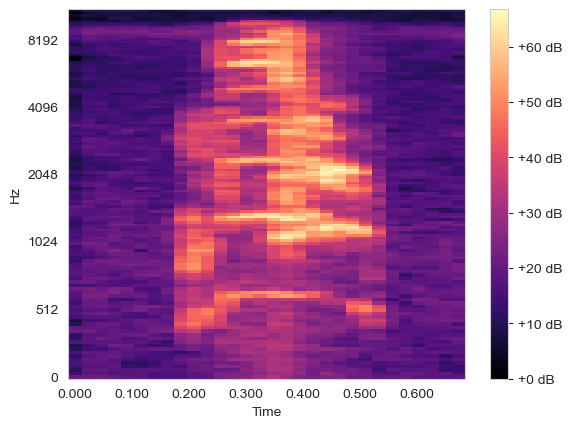

In [30]:
##just to check

librosa.display.specshow(arrs[5], x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')


In [31]:
shapes0 = [_.shape[0] for _ in arrs]
max_shape0 = np.max(shapes0) 
print(max_shape0)
##this is a bit unnecessary because this dimension is the same for all the data, just trying to be consistent with the other dimension
shapes1 = [_.shape[1] for _ in arrs]
#print(shapes1)
max_shape1 = np.max(shapes1)+1 ##I added one for this just to make sure all rows are added 0 (just to make recover easier)
for i in range(len(shapes1)):
    if shapes1[i]>60:
        print(i)

128
91


Two versions of the data are presented below. (1. Matrix(padded with -1) 2. Array(padded with 0 at the beginning and the end))





1. In the cell below, I filled in with "-1" instead of "0", because I'm afraid adding zeros whould change the figure, so I added -1 because -1 wasn't there in the original data. This should be good for future convenience to remove it.


In [32]:
spec_data = []
for i in range(len(arrs)):
    spec_data.append(np.pad(arrs[i], ((0, 0), (max_shape0-arrs[i].shape[0], max_shape1 - arrs[i].shape[1])), mode='constant',constant_values=-1))

spec_data = np.array(spec_data) ##transfered it to numpy array
    

In [33]:
spec_data.shape


(440, 128, 64)

In [34]:
np.save(save_fp,spec_data)

Load data

In [35]:

##let's try to see how to recover the data without -1. 
spec_load = np.load(save_fp)

arrs_load = []
for i in range(spec_load.shape[0]):
    unpadded_indice = np.argmax(spec_load[i][0] == -1)##I have no idea why this should be argmax, but it works
    #print(unpadded_indice)
    unpadded_array = spec_load[i][:, :unpadded_indice]
    arrs_load.append(unpadded_array)

In [36]:
#for i in range(len(arrs)):
    #print(arrs[i]-arrs_load[i])
    
##okay, recovered!!

(128, 21)

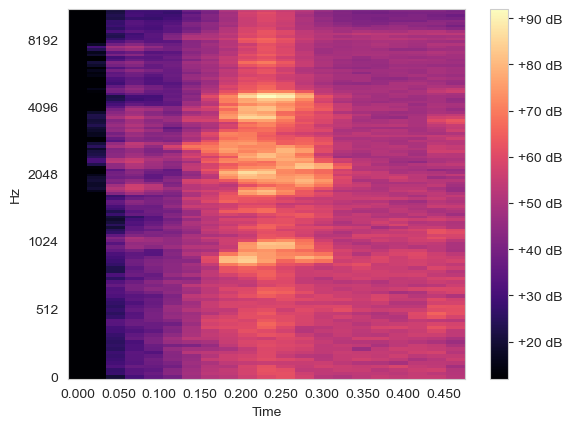

In [159]:
librosa.display.specshow(arrs_load[90],x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')
arrs_load[90].shape


2. But perhaps filled with 0 is also fine, because "0" present total silence. Here is data filled with zeros.

In [38]:
spec_data0 = []
for i in range(len(arrs)):
    pad_b = (max_shape1 - arrs[i].shape[1])//2
    pad_e =  max_shape1 -arrs[i].shape[1] - pad_b
    pad_width = ((1,1),(pad_b,pad_e))
    spec_pad_matrx = np.pad(arrs[i], pad_width, mode='constant',constant_values=0)
    spec_data0.append(spec_pad_matrx)
spec_data0 = np.array(spec_data0) ##transfered it to numpy array
np.save('../../data/processed_data/specgram_db0.npy',spec_data0)


Padded the edges. This data should be more suitable for CNN, but still... The time difference is too large. We might want to dump some of the data, really? The max is of size 64 and the min is of size 17... 

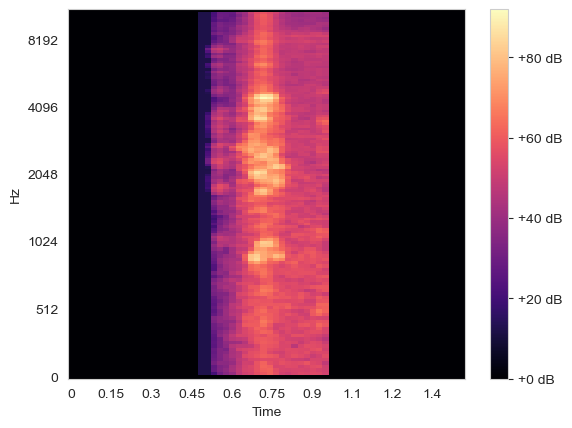

In [39]:
librosa.display.specshow(spec_data0[90], x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')

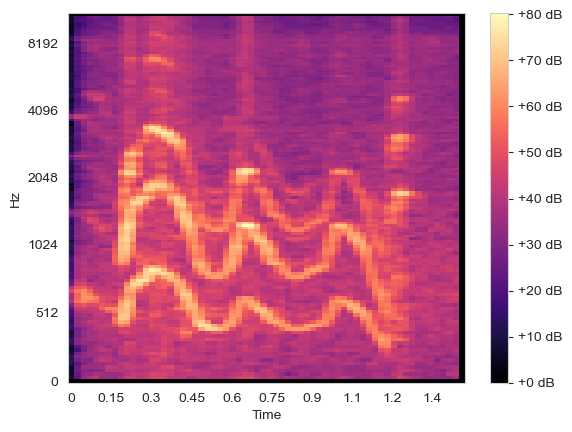

In [51]:
librosa.display.specshow(spec_data0[91], x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')


3. Pad to the beginning and end of the flattened array

In [41]:
data_fps = glob.glob(os.path.join(data_dir, '*'))
arrs_flat = []
maxl = 0
for data_fp in data_fps:
    datalib, ratelib = librosa.load(data_fp, sr=None)
    specgram = librosa.stft(datalib)
    specmag,_ = librosa.magphase(specgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=specmag,sr=ratelib)
    mel_spec_db = librosa.amplitude_to_db(mel_scale_sgram,ref=np.min)
    mel_spec_db_flatten = mel_spec_db.flatten()
    arrs_flat.append(mel_spec_db_flatten)
    maxl = max(maxl,len(mel_spec_db_flatten))

In [50]:
arrs_flat_pad = []
for i in range(len(arrs_flat)):
    pad_width = (maxl-len(arrs_flat[i]))//2
    padl = (pad_width,pad_width)
    melspecflat_new = np.pad(arrs_flat[i], pad_width, mode='constant', constant_values=0)
    arrs_flat_pad.append(melspecflat_new)
mel_flat_pad_nparray = np.array(arrs_flat_pad)

In [51]:
np.save('../../data/processed_data/specgram_db_pad_flatten.npy',mel_flat_pad_nparray)

Now try to resize the audio file by adding truncation

In [53]:
## find out how many time shall I perserve
shapelst = []
for data_fp in data_fps:
    datalib, ratelib = torchaudio.load(data_fp)
    shapelst.append(datalib.shape[1])

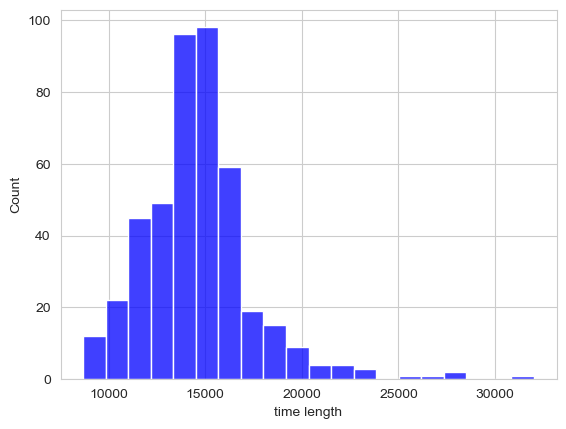

In [58]:
sns.histplot(shapelst, bins=20, color='blue', kde=False)

plt.xlabel('time length')

plt.show()


In [84]:
def pad_trunc(aud, max_t): ## this function is copied and modified from the link: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = max_t

    if (sig_len > max_len):
      # Truncate the signal to the given length
        tru_begin = (sig_len - max_len)//2
        tru_end = max_len + tru_begin
        sig = sig[:,tru_begin:tru_end]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
        pad_begin_len = (max_len - sig_len)//2
        pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

In [203]:
data_fp_sp = data_dir + 'B_BRI01_MC_FI_SIM01_202.wav'

In [204]:
aud = torchaudio.load(data_fp_sp)
aud[0].shape

torch.Size([1, 32012])

In [205]:
audnew = pad_trunc(aud,23000)

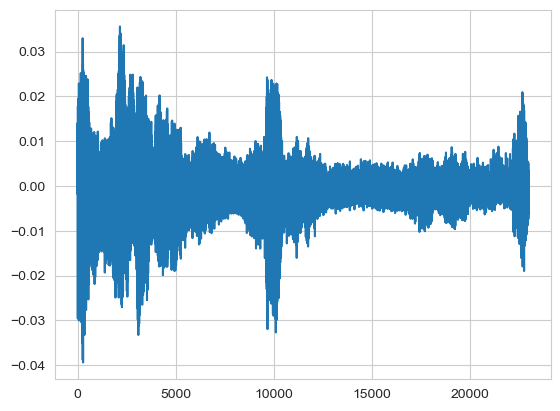

In [206]:
audnew_lst=np.array(audnew[0])[0,:]
plt.plot(
    np.arange(audnew_lst.size),
    audnew_lst,
)


/var/folders/2s/1wkfx2cd65169xd77m_hy0pm0000gq/T/ipykernel_7986/3908831630.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate,sampledata = wavfile.read(data_fp_sp)


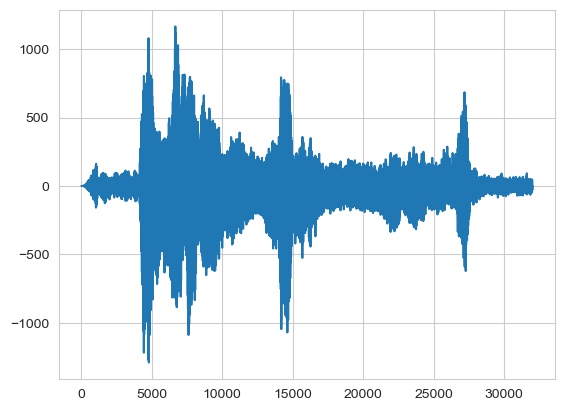

In [207]:
samplerate,sampledata = wavfile.read(data_fp_sp)
plt.plot(
    np.arange(sampledata.size),
    sampledata,
)


In [218]:
def spectro_gram(aud, n_mels=128, n_fft=600, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

In [219]:
spec_sample = spectro_gram(audnew)
np.array(spec_sample).shape

(1, 128, 67)

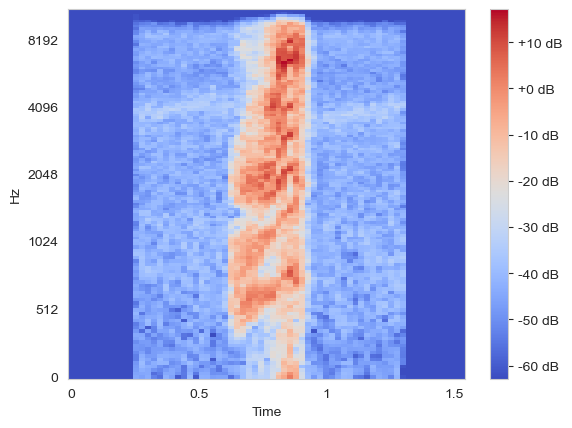

In [220]:
librosa.display.specshow(np.array(spec_sample)[0,:,:], x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [221]:
###loop over all the data, pad and truncate the original data, then transfer it to a spectrogram.
spec_pad_trunc = []
spec_pad_trunc_flat = [] ##flattened version
for data_fp in data_fps:
    aud = torchaudio.load(data_fp) ##load the audio
    audnew = pad_trunc(aud,20000) ##pad or truncate it
    spec = spectro_gram(audnew) ##transform the audo to a spec
    spec_pad_trunc.append(np.array(spec)[0,:,:]) ##save it. Note:transfer tensor to array will lead on one redundant dimension, here we get rid of it
    spec_pad_trunc_flat.append(np.array(spec)[0,:,:].flatten())

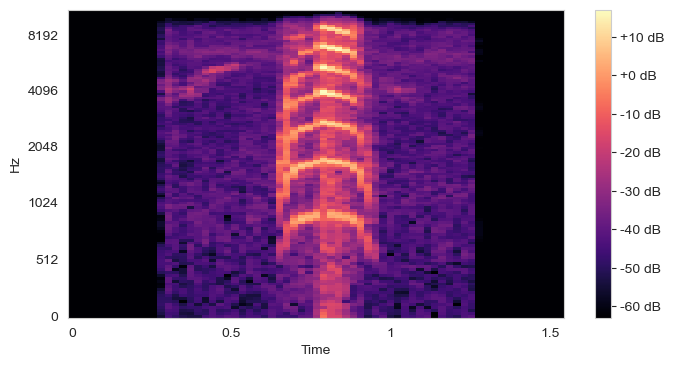

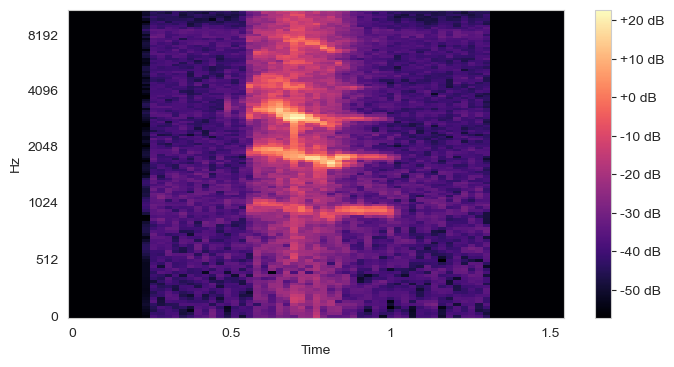

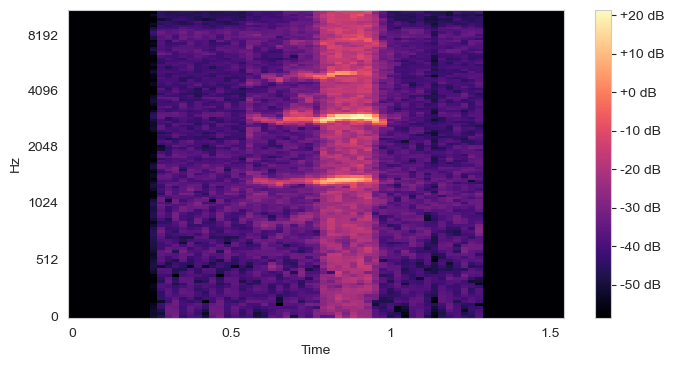

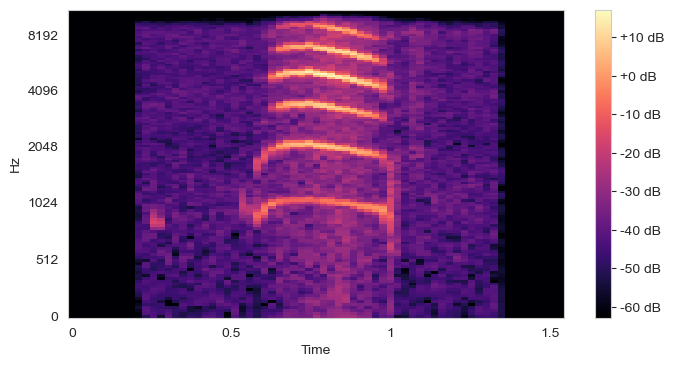

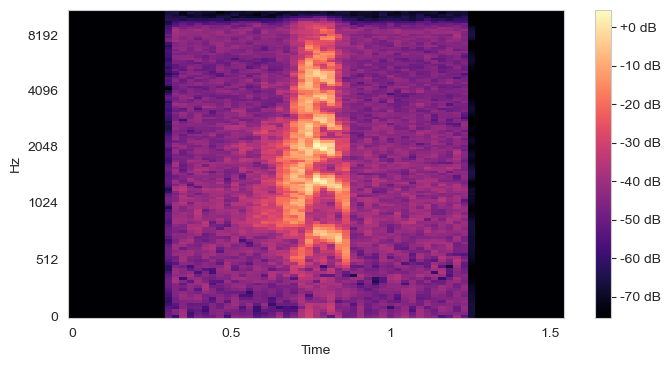

In [222]:
##check how it looks like
for i in range(5):
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(spec_pad_trunc[i], x_axis='time',y_axis='mel')
    plt.colorbar(format='%+2.0f dB')

In [223]:
np.save('../../data/processed_data/specgram_db_pad_trunc.npy',spec_pad_trunc)

In [224]:
##flattened version
np.save('../../data/processed_data/specgram_db_pad_trunc_flattened.npy',spec_pad_trunc_flat)